# Защита персональных данных клиентов

## Загрузка данных

Импортируем нужные для работы библиотеки:

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

Посмотрим общую информацию об имеющихся данных:

In [3]:
data = pd.read_csv('/datasets/insurance.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [4]:
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


Приведем столбцы к нижнему регистру, затем - к змеиному. Также сменим тип данных для столбца "Возраст", т.к. значение целочисленное.

In [5]:
data.columns = data.columns.str.lower()
data.columns

Index(['пол', 'возраст', 'зарплата', 'члены семьи', 'страховые выплаты'], dtype='object')

In [6]:
data = data.rename(columns={'страховые выплаты':'страховые_выплаты', 'члены семьи':'члены_семьи'})

In [7]:
data['возраст'] = data['возраст'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   пол                5000 non-null   int64  
 1   возраст            5000 non-null   int64  
 2   зарплата           5000 non-null   float64
 3   члены_семьи        5000 non-null   int64  
 4   страховые_выплаты  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


В данной ситуации (со столбцами, которые предполагают не уникальные данные), дубли имеют место быть. Не будем их убирать.

In [8]:
numeric = ['возраст', 'зарплата', 'члены_семьи', 'страховые_выплаты']
data[numeric].corr()

,возраст,зарплата,члены_семьи,страховые_выплаты
возраст,1.000000,-0.019093,-0.006692,0.651030
зарплата,-0.019093,1.000000,-0.030296,-0.014963
члены_семьи,-0.006692,-0.030296,1.000000,-0.036290
страховые_выплаты,0.651030,-0.014963,-0.036290,1.000000


<AxesSubplot:>

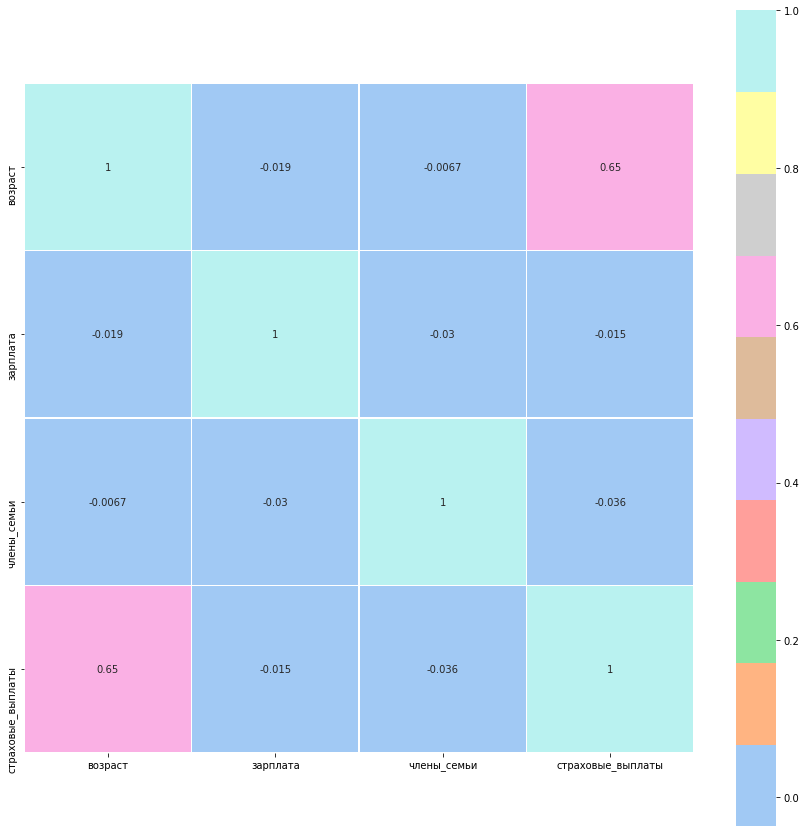

In [9]:
fig = plt.figure(figsize = (15,15))
sns.heatmap(data[numeric].corr(), annot = True, cmap=sns.color_palette("pastel", as_cmap=True), linewidth=.5, square=True)

Посмотрим на распределение признаков:

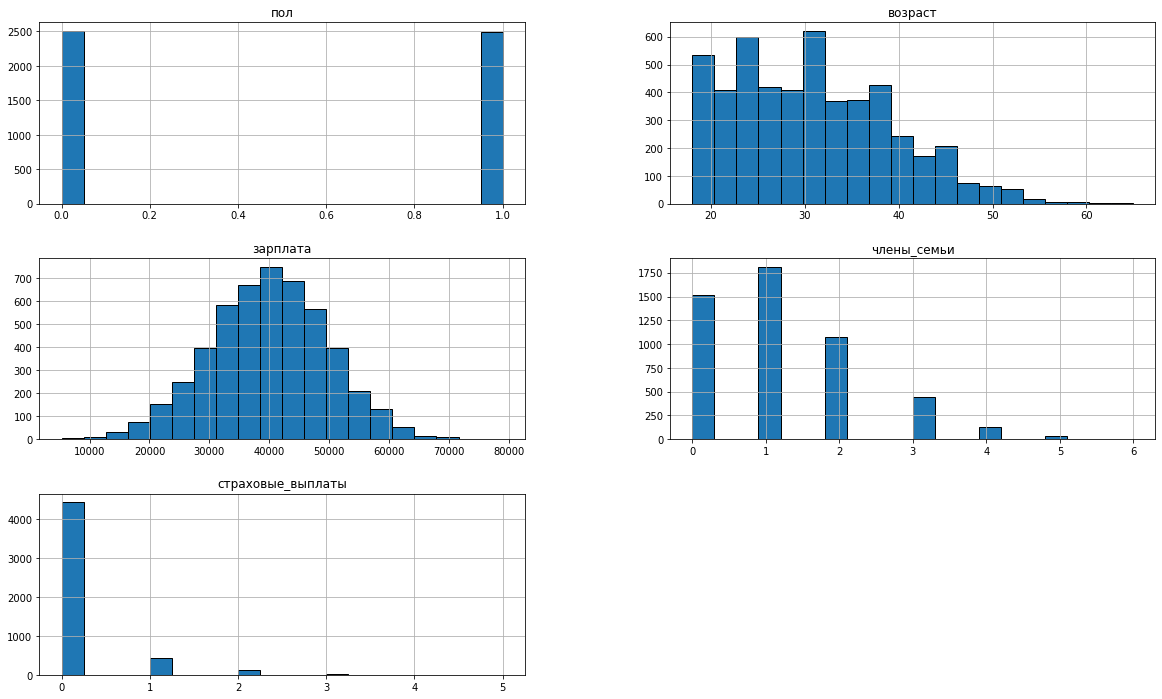

In [39]:
distr = data.hist(bins=20, figsize=(20, 12), edgecolor='black')
plt.show()

Text(0.5, 1, 'Отношения между признаками')

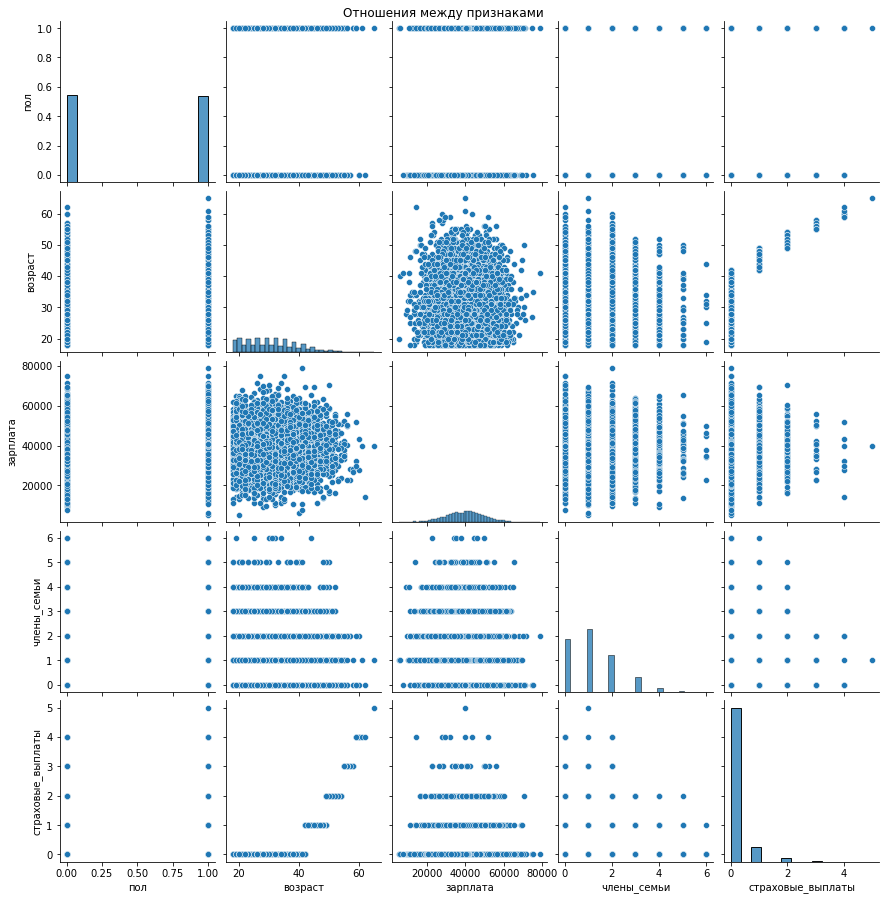

In [28]:
gigaplot = sns.pairplot(data)
gigaplot.fig.suptitle("Отношения между признаками", y=1)

Вывод по разделу: <p>
 - Получили общую информацию о датасете.
 - Привели названия столбцов к нижнему змеиному регистру.
 - Аномалий и пропусков в данных не обнаружили.
 - По матрице корелляции увидели среднюю зависимость между возрастом клиента и страховыми выплатами.

## Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$


**Ответ:** <p>
Умножение признаков на обратимую матрицу не влияет на качество линейной регрессии.

**Обоснование:** <p>

$$
w_1 = ((XP)^TXP)^{-1}(XP)^T y = (P^TX^TXP)^{-1}P^TX^Ty = P^{-1}(X^TX)^{-1}(P^T)^{-1}P^TX^Ty = P^{-1}(X^TX)^{-1}X^Ty
$$
    
$$
a_1 = XPw_1
$$
    
$$
a_1 = XPP^{-1}(X^TX)^{-1}X^Ty = X(X^TX)^{-1}X^Ty = Xw
$$

Выражения для a и a_1 идентичны, соответственно, a и a_1 равны. 

## Алгоритм преобразования

**Алгоритм**

1. Разделение выборки на обучающие и целевой признаки.
2. Создание случайной обратимой матрицы
3. Умножение обратной матрицы на матрицу признаков
4. Проверка обратимости матрицы
5. Обучение модели и расчет показателя R2 для исходных данных
6. Обучение модели и расчет показателя R2 для преобразованных данных

In [8]:
features = data.drop(columns='страховые_выплаты')
target = data['страховые_выплаты']

features.shape, target.shape

((5000, 4), (5000,))

**Обоснование**

Качество линейной регрессии не изменится при умножении матриц, значит, будет целесообразно применить данный алгоритм для целей шифрования.

Создадим матрицу 4х4:

In [9]:
matrix = np.random.normal(size=(features.shape[1], features.shape[1]))
matrix

array([[ 1.16034951,  1.06411647,  2.45657966, -0.17571561],
       [ 2.728668  ,  0.0575881 , -0.71498757, -0.91276988],
       [ 0.91723885,  0.55792097,  0.06710459, -1.35857268],
       [ 0.40663582, -1.14174846,  1.04088071,  1.55020874]])

И проверим ее обратимость:

In [10]:
np.linalg.inv(matrix) @ matrix

array([[ 1.00000000e+00, -3.91210613e-17, -8.69061334e-18,
        -1.76539779e-17],
       [-3.49836963e-16,  1.00000000e+00,  8.07396543e-17,
        -4.91183652e-17],
       [ 7.00523881e-17,  2.69317193e-18,  1.00000000e+00,
        -1.12367167e-16],
       [-1.55121009e-16, -9.88585066e-17,  3.18952417e-16,
         1.00000000e+00]])

Матрицу можно считать обратимой (при двойной инверсии мы получаем единицы на главной диагонали, а в остальных местах - нули (в данном случае - числа, приближенные к нулю, но, вероятно, дело в перемножении чисел с большой разрядностью в пайтоне)). 

Зашифруем целевой признак с помощью созданной матрицы  

In [11]:
features_encrypted = features @ matrix
features_encrypted

,0,1,2,3
0,45608.489093,27675.163603,3302.570812,-67421.254012
1,34981.001480,21202.504172,2518.126009,-51666.199055
2,19341.147120,11718.010429,1388.461826,-28556.496612
3,38306.975142,23264.230311,2785.328575,-56668.548516
4,24017.496912,14564.413906,1733.866820,-35484.480227
...,...,...,...,...
4995,32822.642748,19917.107606,2377.696101,-48523.501824
4996,48156.496834,29235.875086,3493.012008,-71218.692412
4997,31149.783482,18912.389155,2262.627733,-46070.768841
4998,30056.121189,18242.921535,2184.169706,-44440.932671


## Проверка алгоритма

Сравним исходную модель и модель с преобразованными данными: 

In [14]:
lr = LinearRegression()
lr.fit(features, target)
preds = lr.predict(features)
r2_lr = r2_score(target, preds)

print('Значение R2-метрики:', r2_lr)

Значение R2-метрики: 0.4249455028666801


In [15]:
lr_enc = LinearRegression()
lr_enc.fit(features_encrypted, target)
preds_enc = lr_enc.predict(features_encrypted)
r2_lr_enc = r2_score(target, preds_enc)

print('Значение R2-метрики на преобразованных данных:', r2_lr_enc)

Значение R2-метрики на преобразованных данных: 0.42494550286667643


Качество линейной регрессии практически не изменилось, значит - наш алгоритм шифрования/преобразования данных сработал корректно.